# Variational AutoEncoder


## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install d2l

In [2]:
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

## 6.1 MNIST dataset

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divded over 10 classes.

In [ ]:
opts = {'batch_size':32, 'shuffle':True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    **opts)
num_classes = 10

## 6.2 Variational Auto Encoder

We will implement a Variational Auto Encoder. This model consists of two networks, an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: Choose an appropriate activation function for the final layer.
            # because we want to generate MNIST data with zero and one value for each pixel
            # we suggest to apply 'sigmoid'
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z)
        eps = torch.randn_like(std_z)
        # TODO: turn the sample ε from N(0,1) into a sample from N(μ,σ)
        return torch.add(torch.multiply(eps, logvar_z), mean_z)

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1,64,7,7)) # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

The decoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for it.


## 6.3 Loss function

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = \log P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we use binary cross entropy for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf), be careful about the minus sign.



In [5]:
def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def kl_loss(mean_z, logvar_z):
    # TODO: your code here
    loss = - 0.5 * torch.sum(torch.subtract(torch.subtract(torch.add(1, torch.log2(torch.pow(logvar_z, 2))),
                                                             torch.pow(mean_z, 2)), torch.pow(logvar_z, 2)))
    return loss

def loss_function(recon_x, x, mean_z, logvar_z):
    l_r = reconstruction_loss(recon_x, x)
    l_kl = kl_loss(mean_z, logvar_z)
    return l_r + l_kl, l_r, l_kl

## 6.4 Training our VAE

In [6]:
def train(model, num_epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_iter):
            X = X.to(device)
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            dec_X, mean_z, logvar_z = model.forward(X)
            loss, loss_r, loss_kl = loss_function(dec_X, X, mean_z, logvar_z)
            # Optimize
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_r, loss_kl, X.shape[0])
            train_loss_r  = metric[0] / metric[2]
            train_loss_kl = metric[1] / metric[2]
            train_loss = train_loss_r + train_loss_kl
            if i > 0 and i % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, None))
        test_loss_r, test_loss_kl = test(model)
        test_loss = test_loss_r + test_loss_kl
        animator.add(epoch+1, (None, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_r:.3f}, test reconstruction loss {test_loss_r:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (X, y) in enumerate(test_iter):
            X = X.to(device)
            # TODO: compute the outputs and loss
            dec_X, mean_z, logvar_z = model.forward(X)
            loss, loss_r, loss_kl = loss_function(dec_X, X, mean_z, logvar_z)

            metric.add(loss_r, loss_kl, X.shape[0])
    test_loss_r  = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_r, test_loss_kl

training loss 157.003, test loss 156.819
training reconstruction loss 148.892, test reconstruction loss 148.786
training KL loss 8.111, test KL loss 8.033


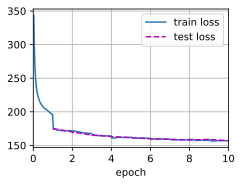

In [7]:
device = d2l.try_gpu()
model = VAE().to(device)
train(model)

**If you increase the numer of latent dimensions, how does that affect the reconstruction loss and the KL loss terms?**

training loss 137.934, test loss 138.504
training reconstruction loss 125.154, test reconstruction loss 125.526
training KL loss 12.780, test KL loss 12.978


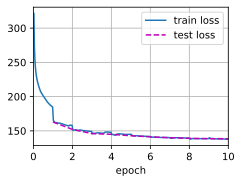

In [ ]:
model2 = VAE(4).to(device)
train(model2)

training loss 161.406, test loss 160.331
training reconstruction loss 154.134, test reconstruction loss 153.255
training KL loss 7.272, test KL loss 7.076


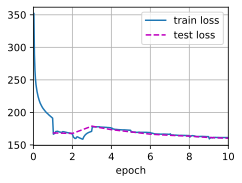

In [ ]:
model3 = VAE(8).to(device)
train(model3)

## 6.5 Visualizing the latent space

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.



In [ ]:
z = model.sample_latent(torch.tensor(1), torch.tensor(1))
z

tensor(1.3977)

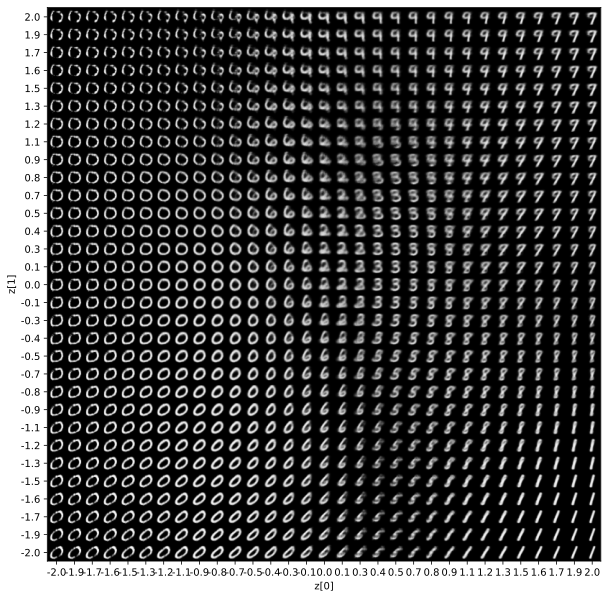

In [ ]:
def plot_latent(model):
    # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            z = [torch.tensor(xi), torch.tensor(yi)]
            x_decoded = model.decode(torch.FloatTensor(z).to(device))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(model)

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.



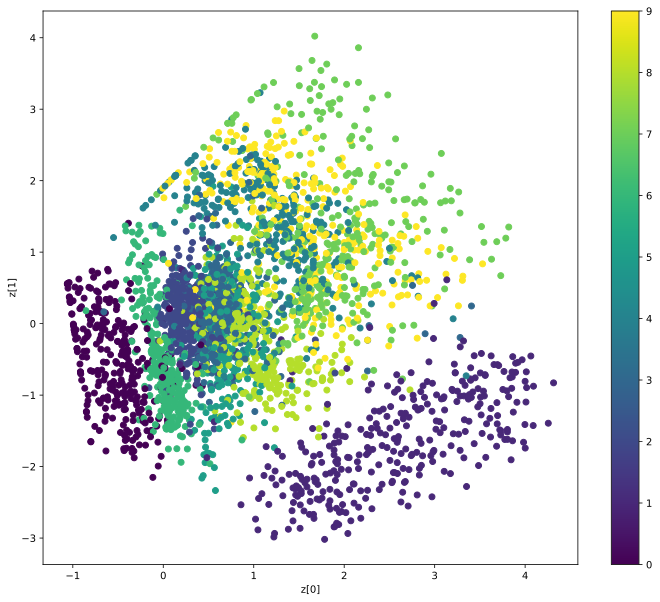

In [ ]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for i, (X, y) in enumerate(train_iter):
        if i > 100: # Limit to a few batches to save memory
            break
        # TODO: compute mean z
        z_mean = model.encode(X.to(device))[0]
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()

    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

scatterplot_latent(model)

## 6.6 Conditional Variational Autoencoder

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this conditional VAE, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z * z + W_y * y + b$.

Similarly for the encoder, except there we will still use a convolutional layer

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # TODO: split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input
        self.encoder_part1_x = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2)
        self.encoder_part1_y = nn.Linear(10, 32*14*14)
        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        # TODO: add layer to use with the y input
        self.decoder_part1_y = nn.Linear(10, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: see VAE
            nn.Sigmoid()
        )

    def encode(self, x, y):
        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1,32,14,14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z)
        eps = torch.randn_like(std_z)
        # TODO: see VAE
        return torch.add(torch.multiply(eps, logvar_z), mean_z)

    def decode(self, z, y):
        # TODO: use a first layer that combines z and y
        h = self.decoder_part1_z(z) + self.decoder_part1_y(y)
        h = torch.reshape(h, (-1,64,7,7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [ ]:
def train_cvae(model, num_epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), F.one_hot(y,10).float().to(device)  # [32, 10]
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            dec_X, mean_z, logvar_z = model.forward(X, y)
            loss, loss_r, loss_kl = loss_function(dec_X, X, mean_z, logvar_z)
            # Optimize
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_r, loss_kl, X.shape[0])
            train_loss_r  = metric[0] / metric[2]
            train_loss_kl = metric[1] / metric[2]
            train_loss = train_loss_r + train_loss_kl
            if i > 0 and i % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, None))
        test_loss_r, test_loss_kl = test_cvae(model)
        test_loss = test_loss_r + test_loss_kl
        animator.add(epoch+1, (None, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_r:.3f}, test reconstruction loss {test_loss_r:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test_cvae(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (X, y) in enumerate(test_iter):
            X, y = X.to(device), F.one_hot(y,10).float().to(device)
            # TODO: compute the outputs and loss
            dec_X, mean_z, logvar_z = model.forward(X, y)
            loss, loss_r, loss_kl = loss_function(dec_X, X, mean_z, logvar_z)

            metric.add(loss_r, loss_kl, X.shape[0])
    test_loss_r  = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_r, test_loss_kl

Train a conditional VAE

training loss 133.065, test loss 133.923
training reconstruction loss 126.756, test reconstruction loss 127.596
training KL loss 6.309, test KL loss 6.327


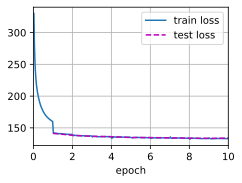

In [ ]:
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model)

In [ ]:
def plot_latent_cond(model, y):
    # display a n*n 2D manifold of digits
    y = torch.tensor(y)
    y = F.one_hot(y,10).float().to(device)
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)          # (n,)
    grid_y = np.linspace(-scale, scale, n)[::-1]    # (n,)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = [torch.tensor(xi), torch.tensor(yi)]
            x_decoded = model.decode(torch.FloatTensor(z).to(device), y)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()



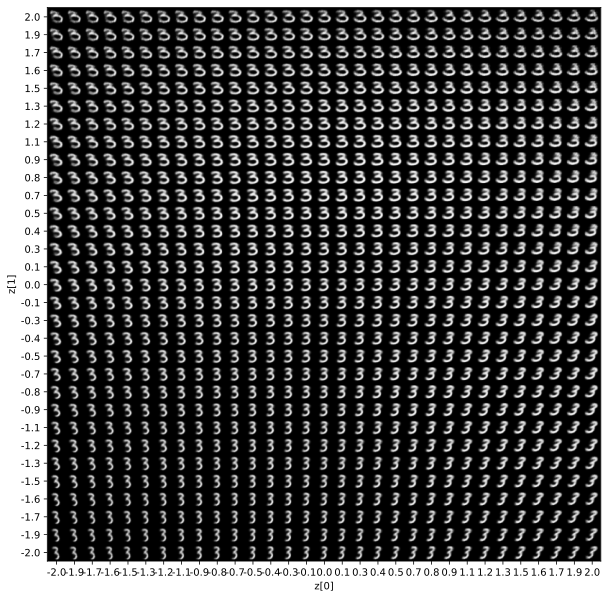

In [ ]:
plot_latent_cond(cvae_model, y=3)

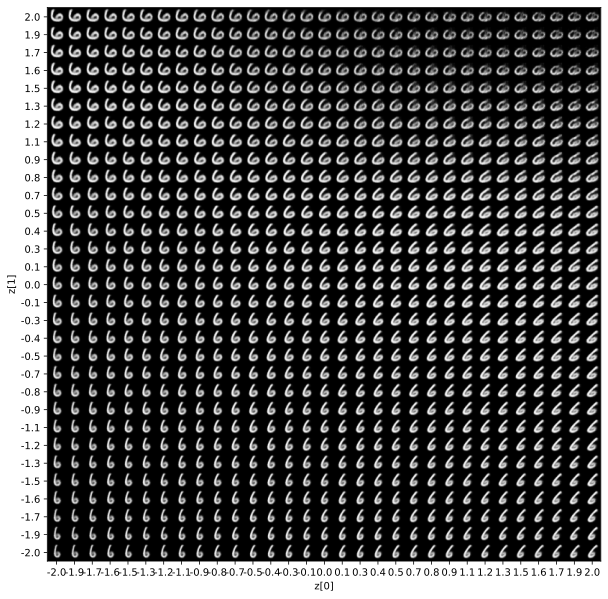

In [ ]:
plot_latent_cond(cvae_model, y=6)

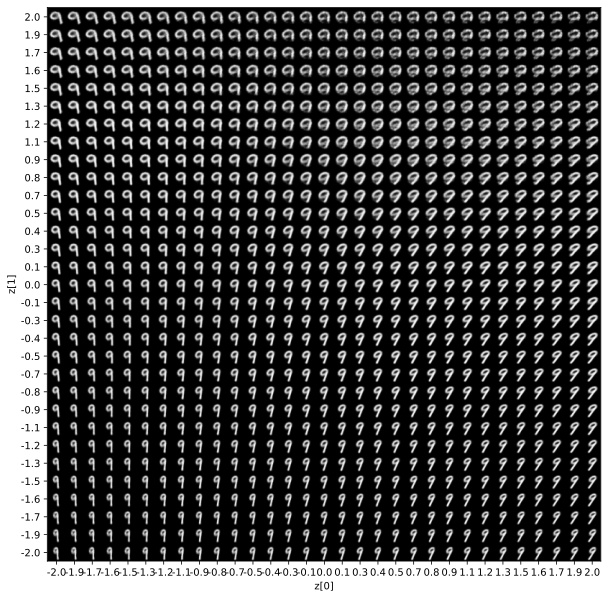

In [ ]:
plot_latent_cond(cvae_model, y=9)